# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

In [36]:
import warnings
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os
from itertools import cycle, islice

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.preprocessing import (
    PolynomialFeatures,
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    PowerTransformer,
)
from sklearn.compose import (
    make_column_transformer,
    TransformedTargetRegressor,
    make_column_selector,
)
from sklearn.utils import Bunch
from sklearn.inspection import permutation_importance
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.metrics import (
    mean_squared_error,
    PredictionErrorDisplay,
    median_absolute_error,
    mean_absolute_error,
    r2_score,
)

from IPython.display import Image

import seaborn as sns

In [4]:
warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
plt.rcParams.update({"axes.grid": True, "figure.figsize": (16, 4)})
sns.set()

In [5]:
df = pd.read_csv("/Users/P2217476/Documents/Training/Module-11/practical_application_II_starter/data/vehicles.csv")
df = df.dropna()

In [6]:
df

,id,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,state
126,7305672709,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,68472.0,clean,automatic,1GCWGAFP8J1309579,rwd,full-size,van,white,al
127,7305672266,auburn,0,2019.0,chevrolet,express cargo van,like new,6 cylinders,gas,69125.0,clean,automatic,1GCWGAFP4K1214373,rwd,full-size,van,white,al
128,7305672252,auburn,0,2018.0,chevrolet,express cargo van,like new,6 cylinders,gas,66555.0,clean,automatic,1GCWGAFPXJ1337903,rwd,full-size,van,white,al
215,7316482063,birmingham,4000,2002.0,toyota,echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,7316429417,birmingham,2500,1995.0,bmw,525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426788,7303227528,wyoming,12995,2016.0,chevrolet,cruze lt,like new,4 cylinders,gas,61127.0,clean,automatic,1G1BE5SM0G7266569,fwd,compact,sedan,silver,wy
426792,7303114896,wyoming,32999,2014.0,ford,"f350, xlt",excellent,8 cylinders,diesel,154642.0,clean,automatic,1FT8W3DT3EEB41548,4wd,full-size,pickup,brown,wy
426793,7303112347,wyoming,15999,2018.0,chevrolet,"cruze, lt",excellent,4 cylinders,gas,36465.0,clean,automatic,1G1BE5SM7J7133704,fwd,mid-size,sedan,black,wy
426833,7302338378,wyoming,6800,1997.0,jaguar,xk8 convertible,good,8 cylinders,gas,69550.0,clean,automatic,SAJGX2749VCOO8376,rwd,compact,convertible,white,wy


### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 34868 entries, 126 to 426836
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            34868 non-null  int64  
 1   region        34868 non-null  object 
 2   price         34868 non-null  int64  
 3   year          34868 non-null  float64
 4   manufacturer  34868 non-null  object 
 5   model         34868 non-null  object 
 6   condition     34868 non-null  object 
 7   cylinders     34868 non-null  object 
 8   fuel          34868 non-null  object 
 9   odometer      34868 non-null  float64
 10  title_status  34868 non-null  object 
 11  transmission  34868 non-null  object 
 12  VIN           34868 non-null  object 
 13  drive         34868 non-null  object 
 14  size          34868 non-null  object 
 15  type          34868 non-null  object 
 16  paint_color   34868 non-null  object 
 17  state         34868 non-null  object 
dtypes: float64(2), int64(2), obj

In [8]:
df.isnull().sum()

id              0
region          0
price           0
year            0
manufacturer    0
model           0
condition       0
cylinders       0
fuel            0
odometer        0
title_status    0
transmission    0
VIN             0
drive           0
size            0
type            0
paint_color     0
state           0
dtype: int64

In [9]:
df.describe()

,id,price,year,odometer
count,3.486800e+04,34868.000000,34868.000000,3.486800e+04
mean,7.311508e+09,15837.446771,2011.176867,1.073991e+05
std,4.299751e+06,13460.056823,7.162332,9.990878e+04
min,7.301592e+09,0.000000,1905.000000,0.000000e+00
25%,7.308189e+09,6500.000000,2008.000000,6.516400e+04
50%,7.312225e+09,12000.000000,2013.000000,1.040000e+05
75%,7.315136e+09,22003.500000,2016.000000,1.411678e+05
max,7.317099e+09,155000.000000,2022.000000,9.999999e+06


In [11]:
# Finding the Objec columns
df.loc[:, df.dtypes == "object"]


,region,manufacturer,model,condition,cylinders,fuel,title_status,transmission,VIN,drive,size,type,paint_color,state
126,auburn,chevrolet,express cargo van,like new,6 cylinders,gas,clean,automatic,1GCWGAFP8J1309579,rwd,full-size,van,white,al
127,auburn,chevrolet,express cargo van,like new,6 cylinders,gas,clean,automatic,1GCWGAFP4K1214373,rwd,full-size,van,white,al
128,auburn,chevrolet,express cargo van,like new,6 cylinders,gas,clean,automatic,1GCWGAFPXJ1337903,rwd,full-size,van,white,al
215,birmingham,toyota,echo,excellent,4 cylinders,gas,clean,automatic,JTDBT123520243495,fwd,compact,sedan,blue,al
219,birmingham,bmw,525i,fair,6 cylinders,gas,clean,automatic,WBAHD6322SGK86772,rwd,mid-size,sedan,white,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426788,wyoming,chevrolet,cruze lt,like new,4 cylinders,gas,clean,automatic,1G1BE5SM0G7266569,fwd,compact,sedan,silver,wy
426792,wyoming,ford,"f350, xlt",excellent,8 cylinders,diesel,clean,automatic,1FT8W3DT3EEB41548,4wd,full-size,pickup,brown,wy
426793,wyoming,chevrolet,"cruze, lt",excellent,4 cylinders,gas,clean,automatic,1G1BE5SM7J7133704,fwd,mid-size,sedan,black,wy
426833,wyoming,jaguar,xk8 convertible,good,8 cylinders,gas,clean,automatic,SAJGX2749VCOO8376,rwd,compact,convertible,white,wy


In [12]:
# Trying to verify the coorelation with the price
df.corr(numeric_only=True)["price"].sort_values(ascending=False)


price       1.000000
year        0.254059
id         -0.049819
odometer   -0.199988
Name: price, dtype: float64

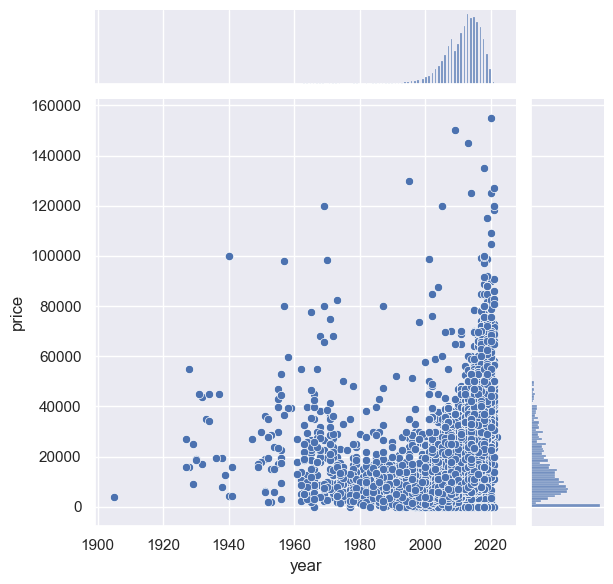

In [13]:
# Trying to build some plots to have visual representation of the data beofre doing our data preparation
sns.jointplot(df, x="year", y="price")


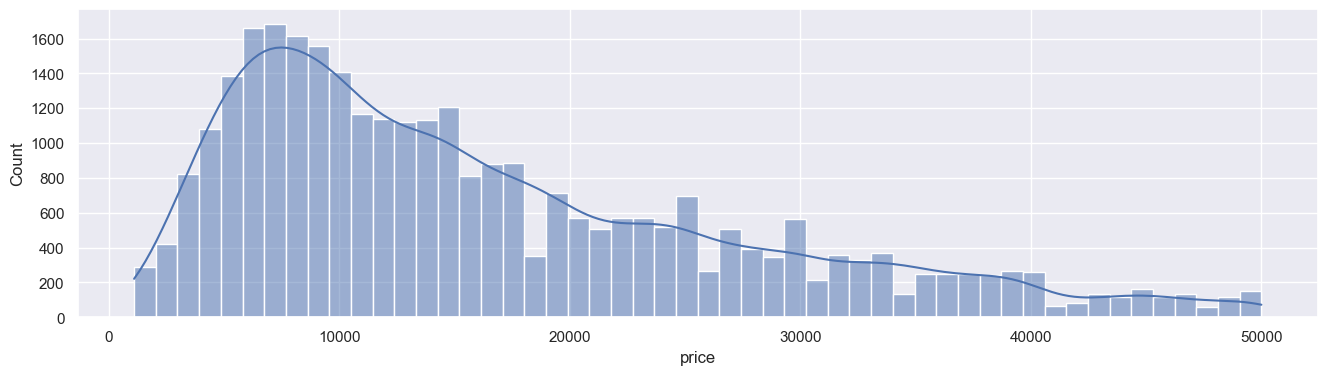

In [15]:
# Building a histo plot for the car within the proce range of 1000 and 500
def sns_histplot(data: pd.DataFrame, x: str = ""):
    sns.histplot(
        data=data,
        x=x,
        kde=True,
        palette=sns.color_palette("bright")[:3],
    )

sns_histplot(df.query("price > 1_000 and price < 50000"), x="price")


### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [ ]:
# In this data preparation, planning to keep the data in a limit to have the right representation

In [16]:
mask = (
    df["price"].between(1_000, 50_000, inclusive="neither")
    & df["odometer"].between(1_000, 300_000, inclusive="neither")
    & df["year"].gt(1990)
)


In [17]:
target_feature = "price"


In [18]:
X = df[mask].drop(columns=[target_feature])
y = df[mask][target_feature]


In [19]:
y.describe()

count    30110.000000
mean     16500.836832
std      11019.060388
min       1095.000000
25%       7990.000000
50%      13500.000000
75%      22995.000000
max      49999.000000
Name: price, dtype: float64

In [20]:
X["condition"].unique()


array(['excellent', 'fair', 'good', 'like new', 'new', 'salvage'],
      dtype=object)

In [21]:
# A set is defined for condition of the category of the car
condition_categories = [
    "new",
    "like new",
    "excellent",
    "good",
    "fair",
    "salvage",
]


In [22]:
# Trying to combine the make and model
X.insert(
    loc=X.columns.get_loc("model") + 1,
    column="make-model",
    value=X["manufacturer"] + " " + X["model"],
)

In [23]:
# Similarly combining the state region 
X.insert(
    loc=X.columns.get_loc("region") + 1,
    column="state-region",
    value=X["state"] + " " + X["region"],
)


In [24]:
# Making the partial VIN data as id
X.insert(
    loc=X.columns.get_loc("VIN") + 1,
    column="VIN_prefix",
    value=X["VIN"].apply(lambda x:x[:8]),
)


In [25]:
X

,id,region,state-region,year,manufacturer,model,make-model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,VIN_prefix,drive,size,type,paint_color,state
215,7316482063,birmingham,al birmingham,2002.0,toyota,echo,toyota echo,excellent,4 cylinders,gas,155000.0,clean,automatic,JTDBT123520243495,JTDBT123,fwd,compact,sedan,blue,al
219,7316429417,birmingham,al birmingham,1995.0,bmw,525i,bmw 525i,fair,6 cylinders,gas,110661.0,clean,automatic,WBAHD6322SGK86772,WBAHD632,rwd,mid-size,sedan,white,al
268,7315946365,birmingham,al birmingham,2008.0,mazda,miata mx-5,mazda miata mx-5,excellent,4 cylinders,gas,56700.0,clean,automatic,JM1NC25F570128735,JM1NC25F,rwd,compact,convertible,white,al
337,7315354216,birmingham,al birmingham,2011.0,ford,f-150,ford f-150,excellent,6 cylinders,gas,164000.0,clean,automatic,1FTMF1CM6BKD55331,1FTMF1CM,fwd,full-size,truck,white,al
355,7315110575,birmingham,al birmingham,2008.0,mercedes-benz,benz c350,mercedes-benz benz c350,good,6 cylinders,gas,129473.0,clean,automatic,WDDGF56X68F140907,WDDGF56X,rwd,full-size,sedan,silver,al
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
426785,7303314912,wyoming,wy wyoming,2015.0,ford,f150 xlt 4x4,ford f150 xlt 4x4,like new,8 cylinders,gas,146795.0,clean,automatic,1FTFX1EF5FFC24427,1FTFX1EF,4wd,full-size,truck,black,wy
426788,7303227528,wyoming,wy wyoming,2016.0,chevrolet,cruze lt,chevrolet cruze lt,like new,4 cylinders,gas,61127.0,clean,automatic,1G1BE5SM0G7266569,1G1BE5SM,fwd,compact,sedan,silver,wy
426792,7303114896,wyoming,wy wyoming,2014.0,ford,"f350, xlt","ford f350, xlt",excellent,8 cylinders,diesel,154642.0,clean,automatic,1FT8W3DT3EEB41548,1FT8W3DT,4wd,full-size,pickup,brown,wy
426793,7303112347,wyoming,wy wyoming,2018.0,chevrolet,"cruze, lt","chevrolet cruze, lt",excellent,4 cylinders,gas,36465.0,clean,automatic,1G1BE5SM7J7133704,1G1BE5SM,fwd,mid-size,sedan,black,wy


### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [27]:
# Train / Test Split 
# 75/25 

(X_train, X_dev, y_train, y_dev, idx_train, idx_dev) = train_test_split(
    X, y, range(len(X)), random_state=42, train_size=0.75
)

In [37]:
# Model helpers

def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "Mean AE": round(mean_absolute_error(y_true, y_pred)),

    }

In [38]:
def make_PredictionErrorDisplay_plot(
    estimator: Pipeline = None,
    description: str = "",
):
    f, ax = plt.subplots(2, 2, sharex=True, figsize=(16, 12))

    for k in range(2):
        ax_row = ax[k]
        if k == 0:
            y_true, y_pred = y_train, estimator.predict(X_train)
        else:
            y_true, y_pred = y_dev, estimator.predict(X_dev)

        # Plot the actual vs predicted values
        PredictionErrorDisplay.from_predictions(
            y_true,
            y_pred,
            kind="actual_vs_predicted",
            ax=ax_row[0],
            scatter_kwargs={"alpha": 0.5},
        )

        ax_row[0].set_title(
            "%s Actual vs. Predicted\nErrors: %s"
            % ("Train" if k == 0 else "Dev", str(compute_score(y_true, y_pred)))
        )

        # plot the residuals vs the predicted values
        PredictionErrorDisplay.from_predictions(
            y_true,
            y_pred,
            kind="residual_vs_predicted",
            ax=ax_row[1],
            scatter_kwargs={"alpha": 0.5},
        )

        ax_row[1].set_title(
            "%s Residual vs. Predicted" % ("Train" if k == 0 else "Dev")
        )

    plt.suptitle(
        description,
        fontsize=16,
        fontweight="bold",
        ha="center",
    )

    plt.tight_layout()
    plt.show()

In [39]:
def grid_search_and_plot(
    estimator: Pipeline = None,
    param_grid: dict = {},
    description: str = "",
):
    if param_grid:
        # Run the grid search
        grid_search = GridSearchCV(
            estimator=estimator,
            param_grid=param_grid,
            scoring="neg_mean_squared_error",
            cv=[[idx_train, idx_dev]],  # hold out
            # cv=5, # kfold
        ).fit(
            X, y
        )  # using all X, y not training partition, because cv does the split for us

        display(grid_search.best_params_)

        # Get best estimator
        best_estimator = grid_search.best_estimator_
    else:
        best_estimator = estimator

    # Fit
    best_estimator.fit(X_train, y_train)

    # Make some performance plots
    make_PredictionErrorDisplay_plot(
        estimator=best_estimator,
        description=description,
    )

    return best_estimator

In [40]:
# Model 1: Liner regression
poly_pipe = Pipeline(
    [
        (
            "scaler",
            make_column_transformer(
                (
                    StandardScaler(),
                    ["year", "odometer"],
                ),
            ),
        ),
        (
            "poly",
            PolynomialFeatures(degree=1, include_bias=False),
        ),
    ]
)

In [41]:
model1 = Pipeline(
    [
        ("transform", poly_pipe),
        ("regression", LinearRegression(fit_intercept=True)),
    ]
)


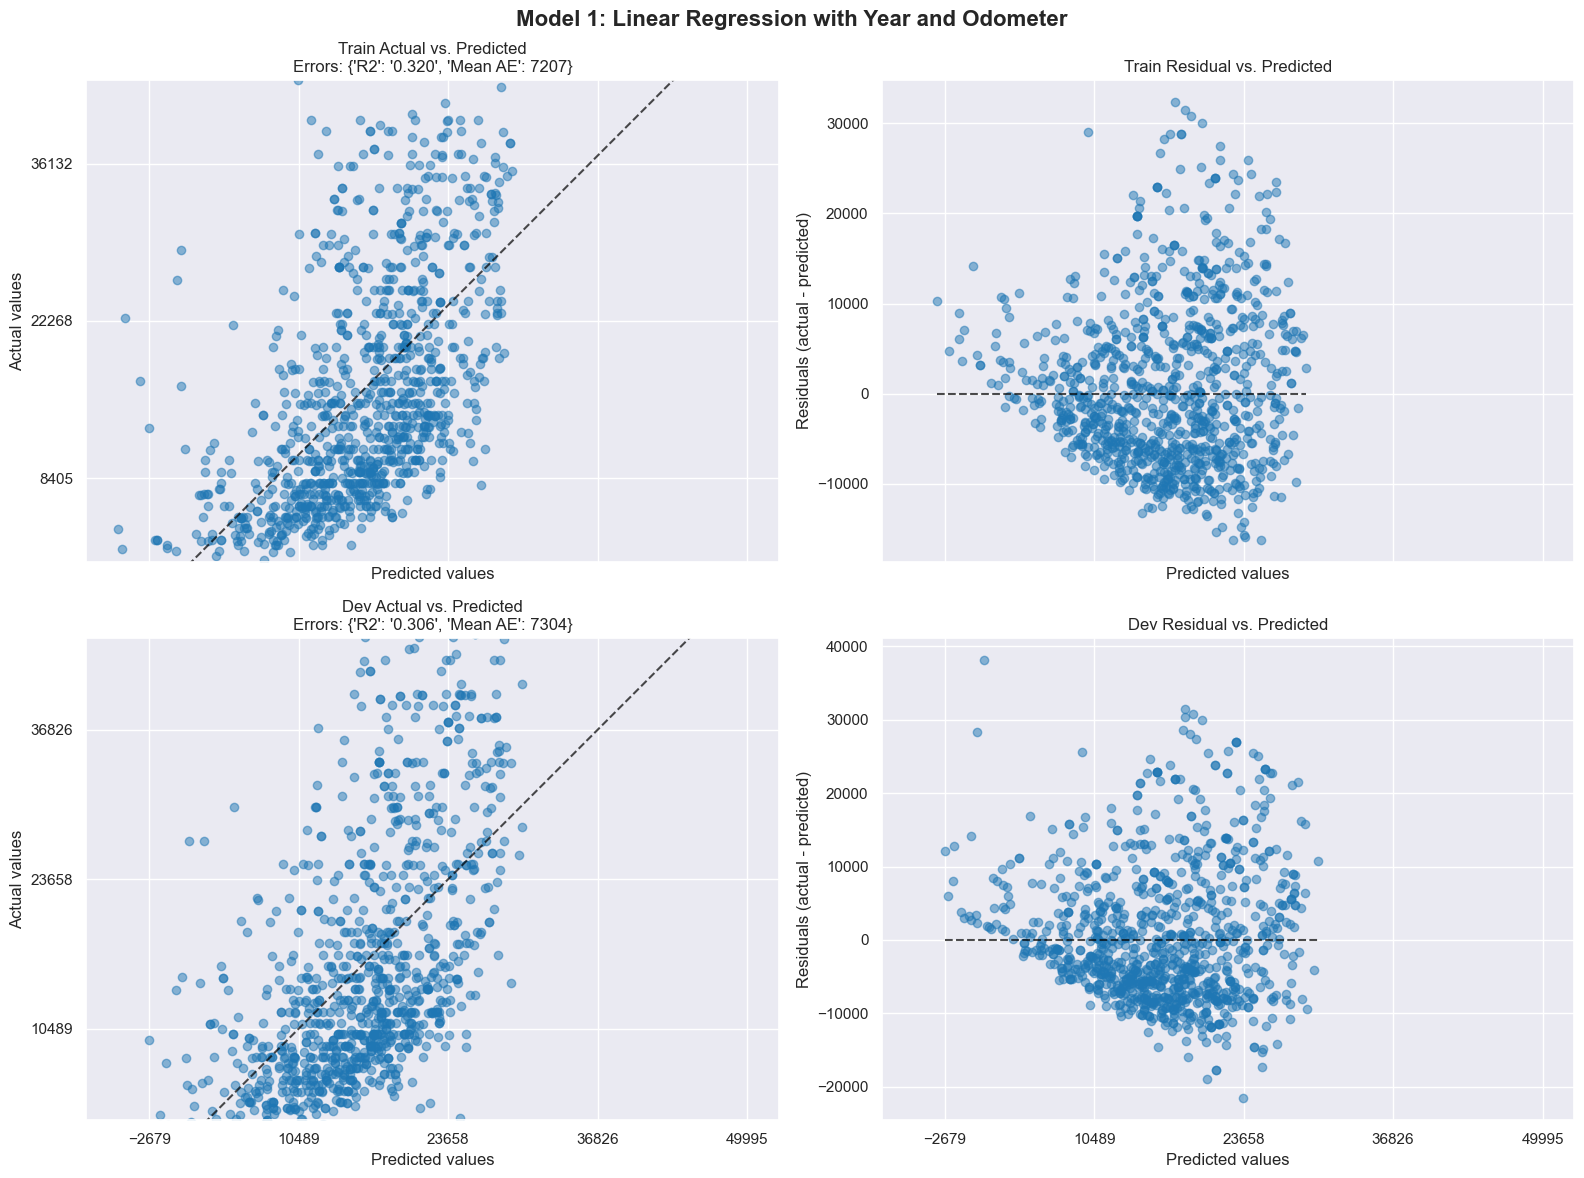

Pipeline(steps=[('transform',
                 Pipeline(steps=[('scaler',
                                  ColumnTransformer(transformers=[('standardscaler',
                                                                   StandardScaler(),
                                                                   ['year',
                                                                    'odometer'])])),
                                 ('poly',
                                  PolynomialFeatures(degree=1,
                                                     include_bias=False))])),
                ('regression', LinearRegression())])

In [42]:
grid_search_and_plot(
    estimator=model1,
    description="Model 1: Linear Regression with Year and Odometer",
)

In [43]:
# Model 2: Basic Ridge , Rgressior is Ridge

model2_categorical_xformer = make_column_transformer(
    (
        OneHotEncoder(drop="if_binary", sparse_output=False, handle_unknown="ignore"),
        ["manufacturer"],
    ),
    (OrdinalEncoder(categories=[condition_categories]), ["condition"]),
)

In [44]:
model2_feature_union = FeatureUnion(
    [
        ("poly_pipe", poly_pipe),
        ("categorical_xformer", model2_categorical_xformer),
    ]
)

In [45]:
if 0:
    model2_feature_union.fit(X)
    display(
        pd.DataFrame(
            model2_feature_union.transform(X),
            columns=model2_feature_union.get_feature_names_out(),
        )
    )

In [46]:
model2 = Pipeline(
    [
        ("feature_union", model2_feature_union),
        ("scaler", StandardScaler()),
        ("ridge", Ridge(fit_intercept=True)),
    ]
)

In [47]:
param_grid = {
    "feature_union__poly_pipe__poly__degree": range(1, 4),
    "ridge__alpha": 10 ** np.linspace(-5, 5, 11),
}

{'feature_union__poly_pipe__poly__degree': 3, 'ridge__alpha': 1e-05}

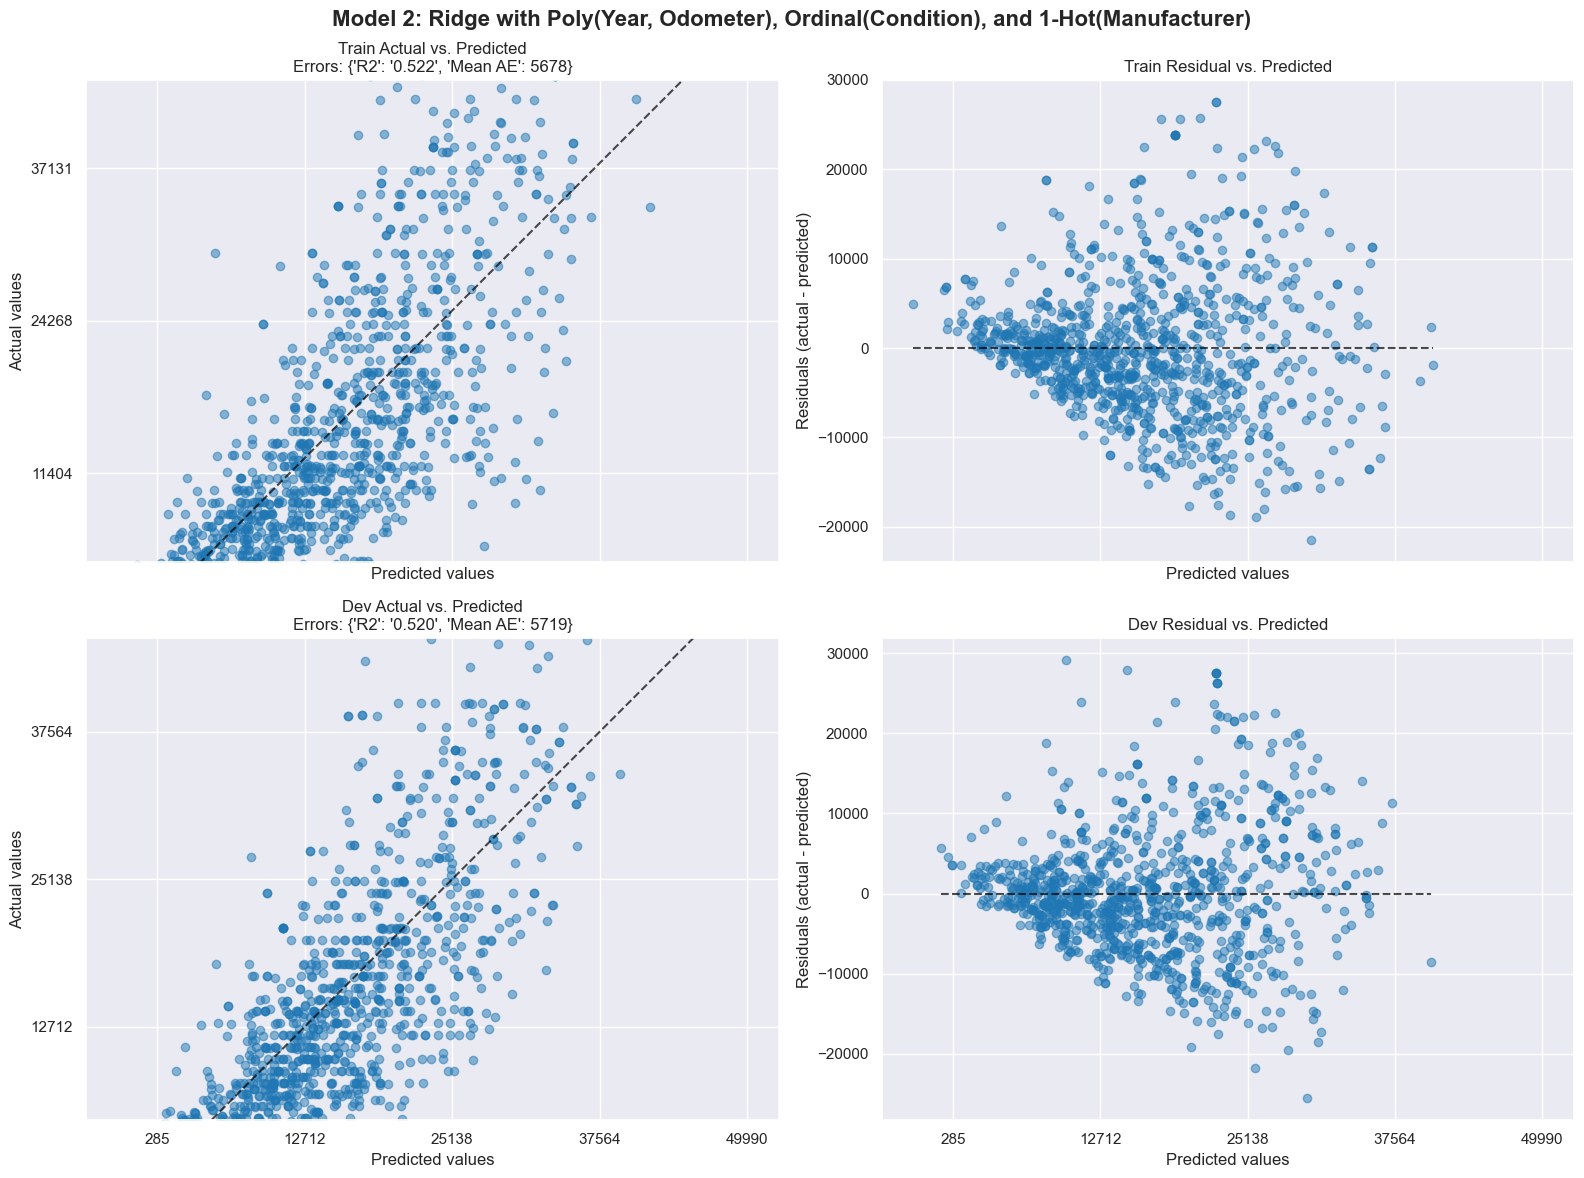

Pipeline(steps=[('feature_union',
                 FeatureUnion(transformer_list=[('poly_pipe',
                                                 Pipeline(steps=[('scaler',
                                                                  ColumnTransformer(transformers=[('standardscaler',
                                                                                                   StandardScaler(),
                                                                                                   ['year',
                                                                                                    'odometer'])])),
                                                                 ('poly',
                                                                  PolynomialFeatures(degree=3,
                                                                                     include_bias=False))])),
                                                ('categorical_xformer',
                                                 ColumnTransformer(transformers=[('onehotencoder',
                                                                                  OneHotEncoder(drop='if_binary',
                                                                                                handle_unknown='ignore',
                                                                                                sparse_output=False),
                                                                                  ['manufacturer']),
                                                                                 ('ordinalencoder',
                                                                                  OrdinalEncoder(categories=[['new',
                                                                                                              'like '
                                                                                                              'new',
                                                                                                              'excellent',
                                                                                                              'good',
                                                                                                              'fair',
                                                                                                              'salvage']]),
                                                                                  ['condition'])]))])),
                ('scaler', StandardScaler()), ('ridge', Ridge(alpha=1e-05))])

In [48]:
grid_search_and_plot(
    estimator=model2,
    param_grid=param_grid,
    description="Model 2: Ridge with Poly(Year, Odometer), Ordinal(Condition), and 1-Hot(Manufacturer)",
)

### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Overall I think the modeling has succeeded in producing a reasonable estimate. If a candidate dealer were using this model, they could estimate, on average, within about $3,000 of the actual price.



### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

Results

The best performance seen thus far has been about $2700. The client can use the performance against this requirement to build in sufficient margin per transaction such that they obtain profitable sales.

The modeling showed that the 3 most important features are

The vehicle's year
Mileage
Make and model




Key Findings

The least important feature was paint color, meaning a client need not be concerned about which color vehicles to offer for sale, as the color had virtually no influence on the price.

The two most common models are pickup trucks, the Ford F-150 and Chevrolet Silverado 1500. The dealers can offer those models and be confident they will appeal to a large number of people. In fact, among the top 10 most commonly sold vehicles, 9 of the 10 were trucks.

The dealer could probably offer nothing but pickup trucks and make plenty of sales.

On the opposite end of the scale, several more expensive European brands were the least commonly sold, including Land Rover, Aston Martin, and Ferrari. Offering these vehicles for sale will appeal to a far narrower audience and may sit for extended periods of time on dealer lots.